<a href="https://colab.research.google.com/github/Gabriele90/ML-in-medical-imaging/blob/main/MRI_brain_segmentation_using_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Summary***

There is large consent that successful training of deep net-
works requires many thousand annotated training samples. In this study, I present a network and training strategy that relies on the strong use of data augmentation to use the available annotated samples more efficiently. The architecture, called UNet looks like a ‘U’ which justifies its name. This architecture consists of three sections: The contraction, The bottleneck, and the expansion section. The contraction section is made of many contraction blocks. Each block takes an input applies two 3X3 convolution layers followed by a 2X2 max pooling. The number of kernels or feature maps after each block doubles so that architecture can learn the complex structures effectively. The bottommost layer mediates between the contraction layer and the expansion layer. It uses two 3X3 CNN layers followed by 2X2 up convolution layer.
But the heart of this architecture lies in the expansion section. Similar to contraction layer, it also consists of several expansion blocks. Each block passes the input to two 3X3 CNN layers followed by a 2X2 upsampling layer. Also after each block number of feature maps used by convolutional layer get half to maintain symmetry. However, every time the input is also get appended by feature maps of the corresponding contraction layer. This action would ensure that the features that are learned while contracting the image will be used to reconstruct it. The number of expansion blocks is as same as the number of contraction block. After that, the resultant mapping passes through another 3X3 CNN layer with the number of feature maps equal to the number of segments desired.
 For this, they must be able to recognize the interested portion and point out relevant facts about the structures being studied.

***Objectives***

This study presents a deep learning framework for semantic segmentation called UNet, to segment brain tumors in MRIs. The proposed network uses MRi images dataset which is composed of images obtained through four different modalities. The network architecture consists of multiple neural network layers connected in sequential order with the feeding of Convolutional feature maps at the peer level. To assess the performance of the architecture I propose two different loss functions: a generalized focal loss function based on the **Tversky index** to address the issue of data imbalance in medical image segmentation, and the **Dice loss**. Both loss functions achieve a great trade off between precision and recall when training on small structures such as lesions.

***Importing libraries***

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
#Set Parameters
im_width = 256
im_height = 256

***Load image's path and mask's path***

In [ ]:
import os
train_files = []
mask_files = glob('/content/drive/MyDrive/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

print(train_files[:10])
print(mask_files[:10])

['/content/drive/MyDrive/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_14.tif', '/content/drive/MyDrive/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_15.tif', '/content/drive/MyDrive/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_13.tif', '/content/drive/MyDrive/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_11.tif', '/content/drive/MyDrive/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_10.tif', '/content/drive/MyDrive/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_16.tif', '/content/drive/MyDrive/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_12.tif', '/content/drive/MyDrive/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_2.tif', '/content/drive/MyDrive/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8111_19980330/TCGA_HT_8111_19980330_18.tif', '/content/drive/MyDrive/lgg-

***Data Visualization***

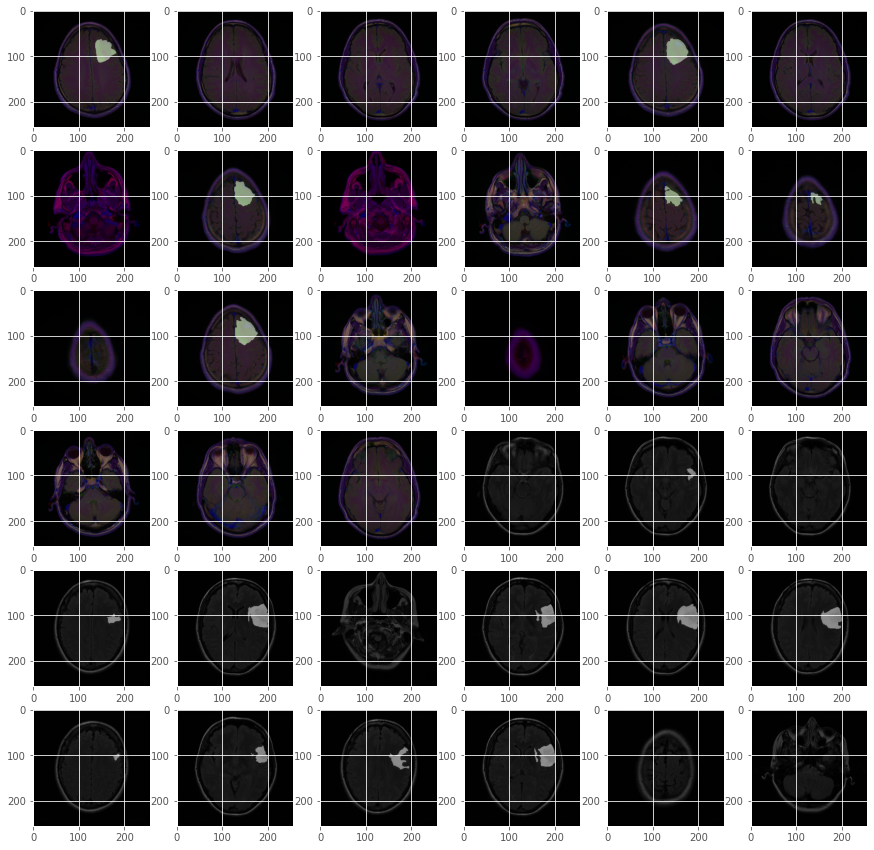

In [ ]:
#Lets plot some samples
rows,cols=6,6
fig=plt.figure(figsize=(15,15))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=train_files[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()

***Data splitting***

Create data frame and split data on train set, validation set and test set

In [ ]:
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2828, 2)
(708, 2)
(393, 2)


***Data generator, data augmentation and adjust data***

We generate image and mask at the same time use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same if you want to visualize the results of generator,set save_to_dir = "your path".

In [ ]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
  image_datagen = ImageDataGenerator(**aug_dict)
  mask_datagen = ImageDataGenerator(**aug_dict)
    
  image_generator = image_datagen.flow_from_dataframe(
      data_frame,
      x_col = "filename",
      class_mode = None,
      color_mode = image_color_mode,
      target_size = target_size,
      batch_size = batch_size,
      save_to_dir = save_to_dir,
      save_prefix  = image_save_prefix,
      seed = seed)
  mask_generator = mask_datagen.flow_from_dataframe(
      data_frame,
      x_col = "mask",
      class_mode = None,
      color_mode = mask_color_mode,
      target_size = target_size,
      batch_size = batch_size,
      save_to_dir = save_to_dir,
      save_prefix  = mask_save_prefix,
      seed = seed)
  train_gen = zip(image_generator, mask_generator)
  for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
  img = img / 255
  mask = mask / 255
  mask[mask > 0.5] = 1
  mask[mask <= 0.5] = 0
  
  return (img, mask)

***Dice coefficient loss***

Now it's time to define the first loss function.
The **Sørensen–Dice coefficient** is used to compared two different statistical samples, but it is also used on image processing areas to match similarity between to binary images.
The loss function is given by the negative of the Dice coefficient.
As it was necessary to use the calculation of Dice coefficient on different moments, considering plotting, logging and the training itself, there are three variations.

In [ ]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

***Define Unet***

Once we have our customised loss function, it's time to define the UNet framework.

In [ ]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)
    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)
    
    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       activation[0][0]                 
______________________________________________________________________________________________

***Training the model***

In [ ]:
EPOCHS = 15
BATCH_SIZE = 32
learning_rate = 1e-4

***Compiling the model***

In [ ]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    
model = unet(input_size=(im_height, im_width, 3))

opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

callbacks = [ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/15
89/88 [==============================] - ETA: -18s - loss: -0.0718 - binary_accuracy: 0.7695 - iou: 0.0379 - dice_coef: 0.0718Found 708 validated image filenames.
Found 708 validated image filenames.
88/88 [==============================] - 3257s 37s/step - loss: -0.0722 - binary_accuracy: 0.7709 - iou: 0.0381 - dice_coef: 0.0722 - val_loss: -0.0210 - val_binary_accuracy: 0.9897 - val_iou: 0.0103 - val_dice_coef: 0.0202

Epoch 00001: val_loss improved from inf to -0.02099, saving model to unet_brain_mri_seg.hdf5
Epoch 2/15
88/88 [==============================] - 141s 2s/step - loss: -0.1765 - binary_accuracy: 0.9859 - iou: 0.0978 - dice_coef: 0.1765 - val_loss: -0.0200 - val_binary_accuracy: 0.9896 - val_iou: 0.0106 - val_dice_coef: 0.0207

Epoch 00002: val_loss did not improve from -0.02099
Epoch 3/15
88/88 [==============================] - 144s 2s/step - loss: -0.2045 - binary_accuracy: 0.9879 - 

***Plot metric scores***

In [ ]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'iou', 'dice_coef', 'val_loss', 'val_binary_accuracy', 'val_iou', 'val_dice_coef'])

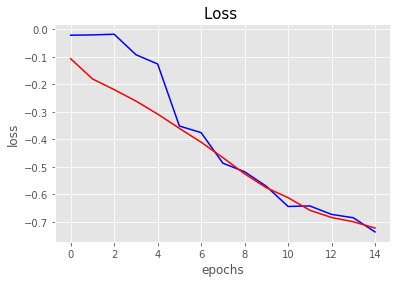

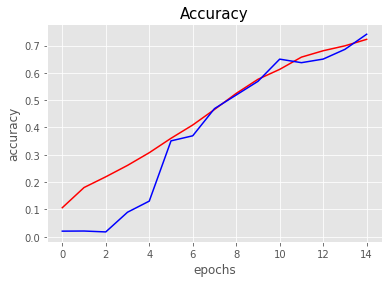

In [ ]:
a = history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainjaccard = a['iou']
list_testjaccard = a['val_iou']

list_trainloss = a['loss']
list_testloss = a['val_loss']
plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss ', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy', fontsize = 15)
plt.show()

In [ ]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'iou', 'dice_coef', 'val_loss', 'val_binary_accuracy', 'val_iou', 'val_dice_coef'])

In [ ]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test loss: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 393 validated image filenames.
Found 393 validated image filenames.
12/12 [==============================] - 321s 28s/step - loss: -0.7074 - binary_accuracy: 0.9957 - iou: 0.5589 - dice_coef: 0.7118
Test loss:  -0.7074262499809265
Test IOU:  0.9957100749015808
Test Dice Coefficent:  0.5589471459388733


As we can see we got a good test loss, an excellent Intersection over union coefficient and a acceptable dice coefficient score for the test set.

***Model application***

Now let's apply our trained model over our fMRI brain dataset and the correspective masks to compare the differences.

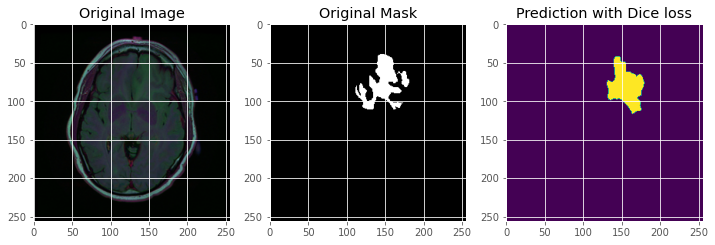

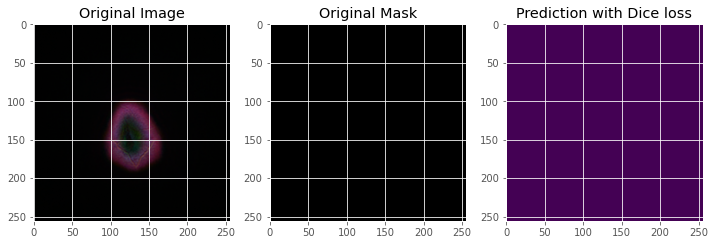

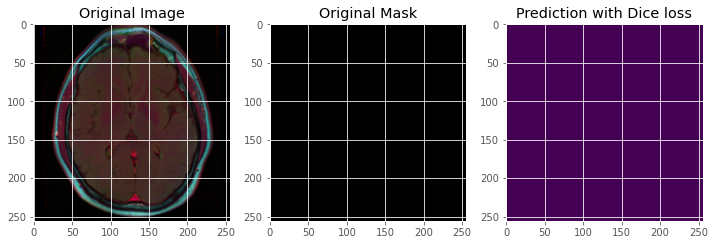

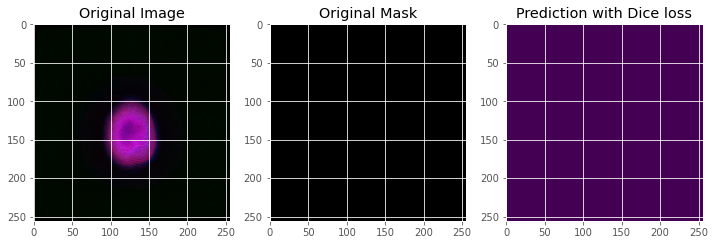

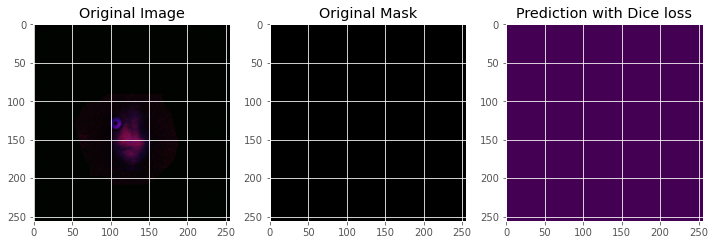

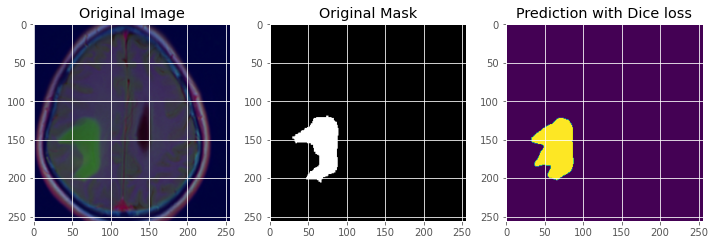

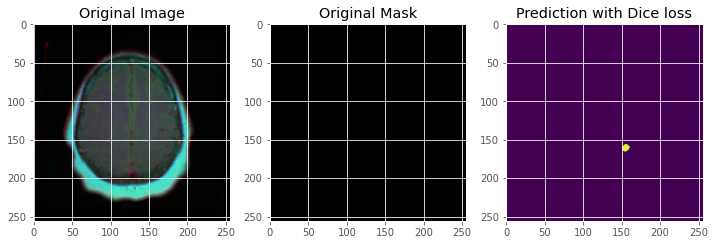

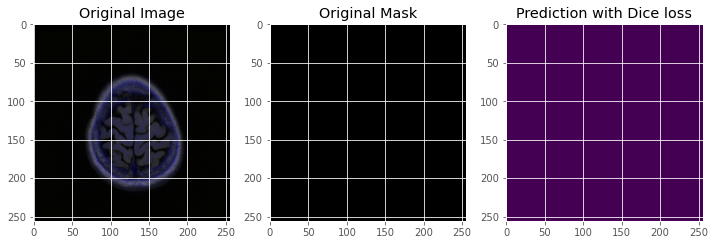

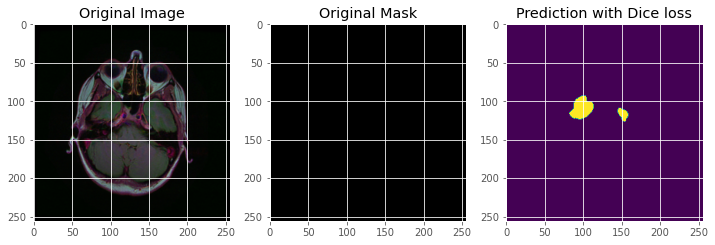

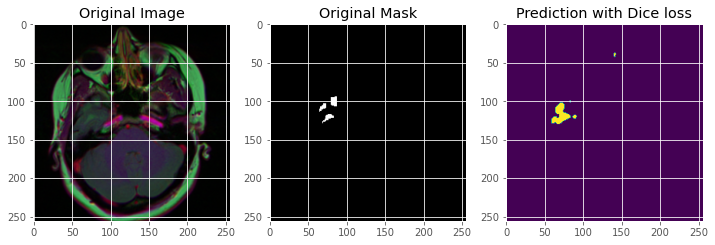

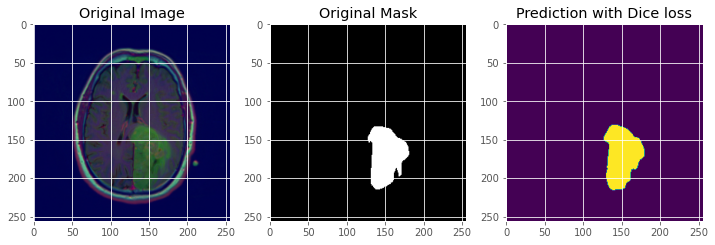

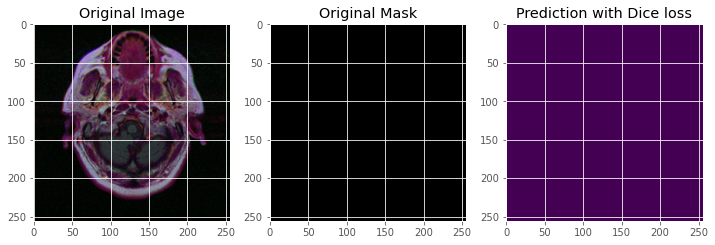

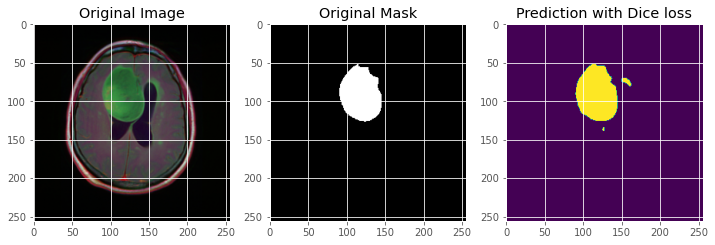

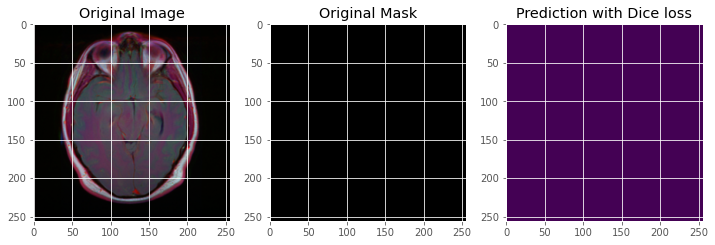

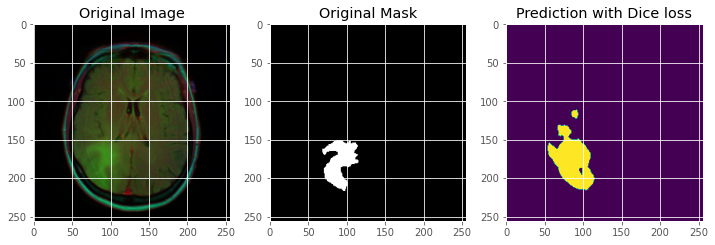

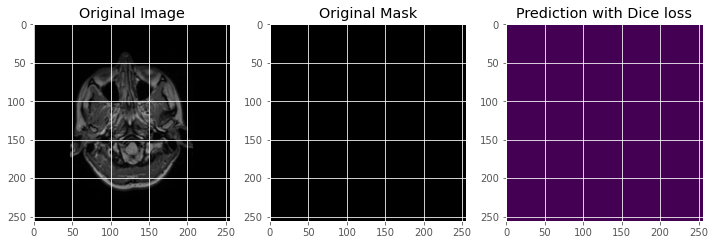

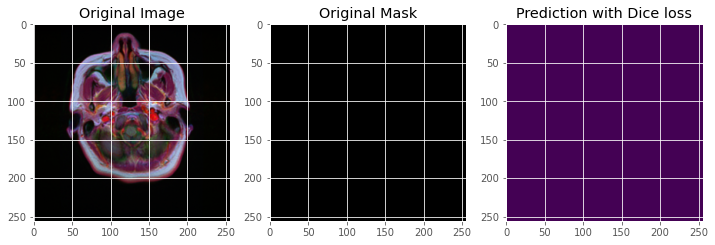

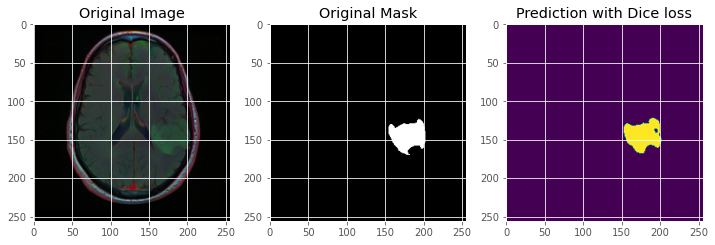

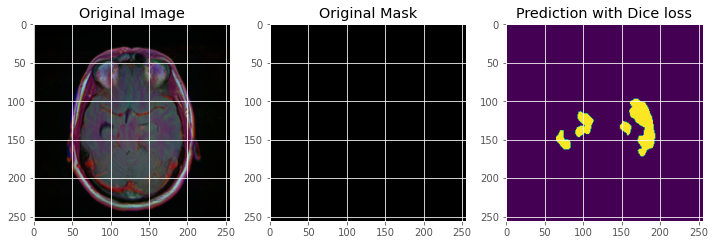

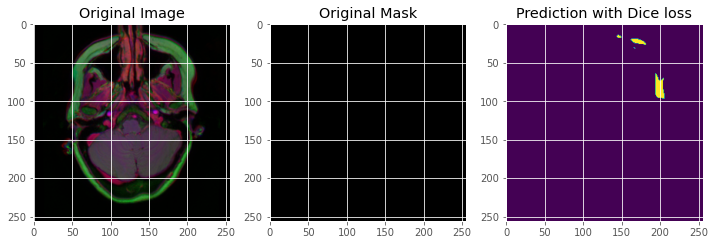

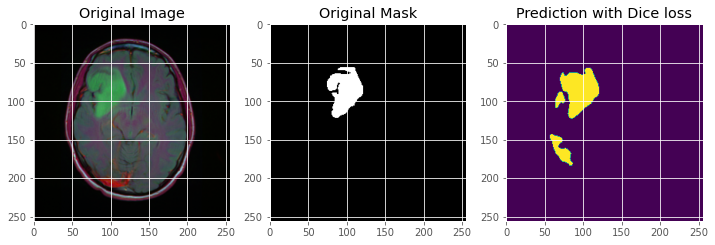

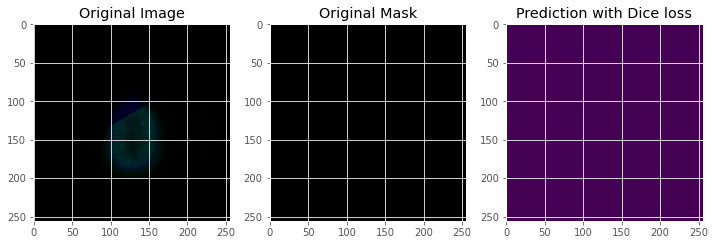

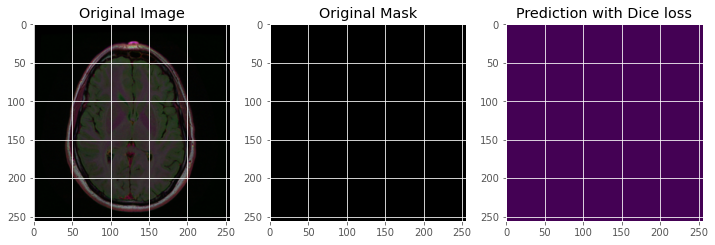

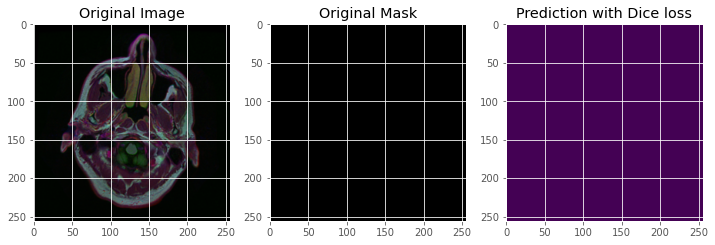

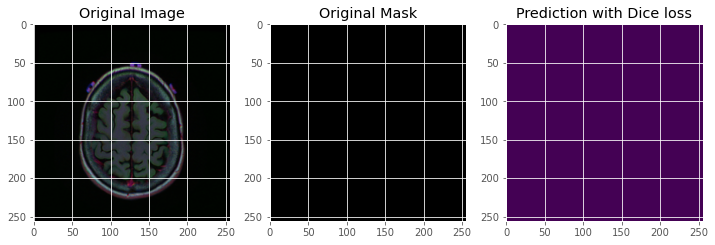

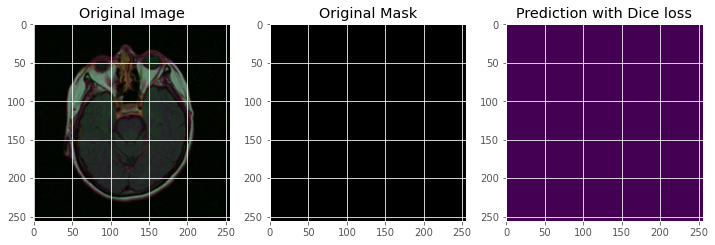

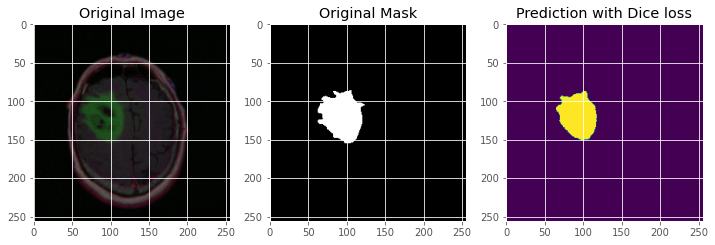

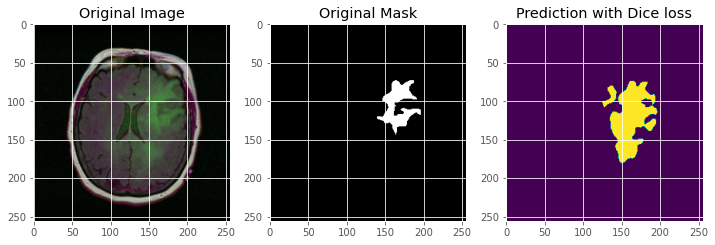

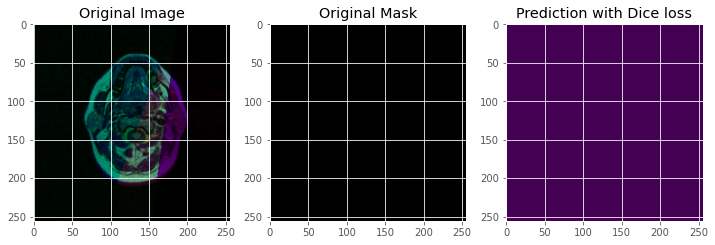

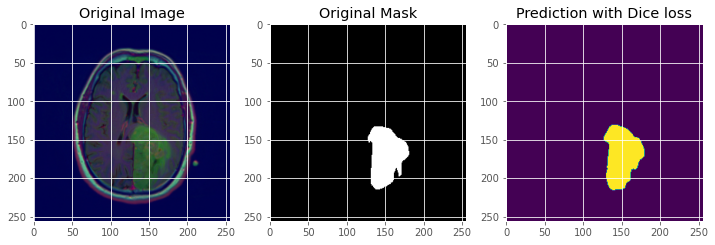

In [ ]:
for i in range(30):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[index])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction with Dice loss')
    plt.show()

As we can see our predicted mask are really similar to the original ones.

***Second approach: UNet with tuersky loss function***

In [ ]:
model_1 = unet()
model_1.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 256, 256, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 256, 256, 64) 0           conv2d_38[0][0]                  
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 256, 64) 36928       activation_36[0][0]              
____________________________________________________________________________________________

***Tuersky loss function***

I propose a generalized loss function based on the Tversky index to address the issue of data imbalance and achieve much better trade-off between precision and recall in training 3D fully convolutional deep neural networks.

In [ ]:
from keras.losses import binary_crossentropy

smooth = 100

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

***Training and compiling the model using the new loss function***

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [ ]:
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_1.compile(optimizer = adam, 
                  loss = focal_tversky, 
                  metrics = [tversky]
                 )
#callbacks
earlystopping_1 = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=20
                             )
# save the best model with lower validation loss
checkpointer_1 = ModelCheckpoint(filepath="UNet-segModel-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr_1 = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

In [ ]:
history_1 = model_1.fit(train_gen, 
                        steps_per_epoch=len(df_train) / BATCH_SIZE, 
                        epochs=EPOCHS,
                        callbacks = [checkpointer_1, earlystopping_1, reduce_lr_1],
                        validation_data = test_gener,
                        validation_steps=len(df_val) / BATCH_SIZE)


Epoch 1/15
88/88 [==============================] - 148s 2s/step - loss: 0.9438 - tversky: 0.0737 - val_loss: 0.9735 - val_tversky: 0.0351

Epoch 00001: val_loss improved from inf to 0.97346, saving model to UNet-segModel-weights.hdf5
Epoch 2/15
88/88 [==============================] - 146s 2s/step - loss: 0.6124 - tversky: 0.4761 - val_loss: 0.7286 - val_tversky: 0.3380

Epoch 00002: val_loss improved from 0.97346 to 0.72857, saving model to UNet-segModel-weights.hdf5
Epoch 3/15
88/88 [==============================] - 145s 2s/step - loss: 0.5099 - tversky: 0.5893 - val_loss: 0.5566 - val_tversky: 0.5365

Epoch 00003: val_loss improved from 0.72857 to 0.55664, saving model to UNet-segModel-weights.hdf5
Epoch 4/15
88/88 [==============================] - 145s 2s/step - loss: 0.4416 - tversky: 0.6598 - val_loss: 0.6440 - val_tversky: 0.4281

Epoch 00004: val_loss did not improve from 0.55664
Epoch 5/15
88/88 [==============================] - 146s 2s/step - loss: 0.4260 - tversky: 0.676

***Plotting results***

In [ ]:
history_1.history.keys()

dict_keys(['loss', 'tversky', 'val_loss', 'val_tversky', 'lr'])

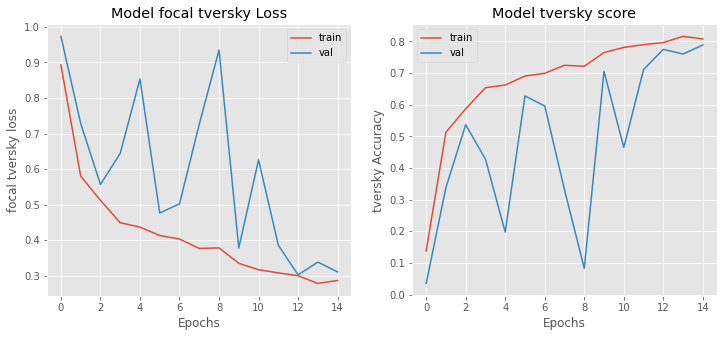

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_1.history['loss']);
plt.plot(history_1.history['val_loss']);
plt.title("Model focal tversky Loss");
plt.ylabel("focal tversky loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(history_1.history['tversky']);
plt.plot(history_1.history['val_tversky']);
plt.title("Model tversky score");
plt.ylabel("tversky Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

We got excellent focal tvuersky loss and tuersky scores!

***Application of the second model***

Now it's time to compare the original mask vs the two predicted masks and see the differences.

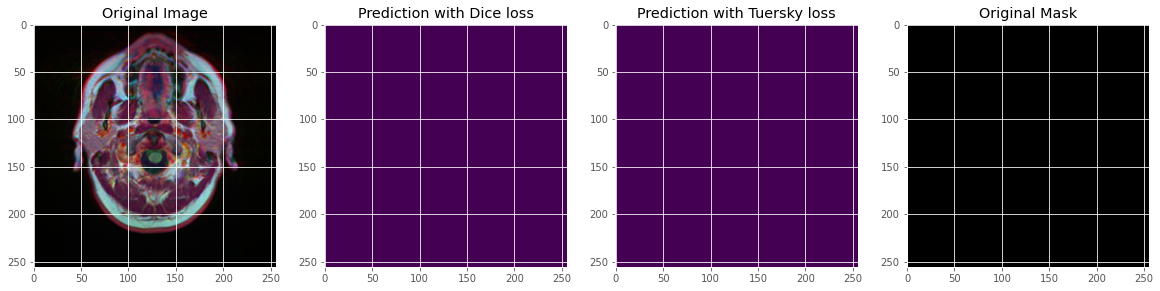

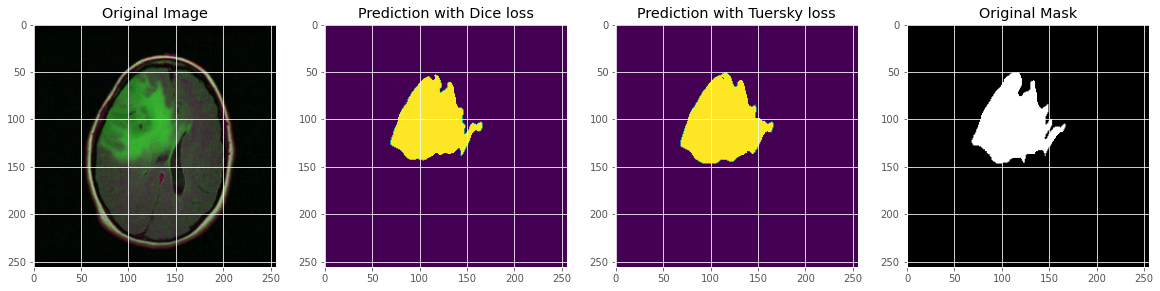

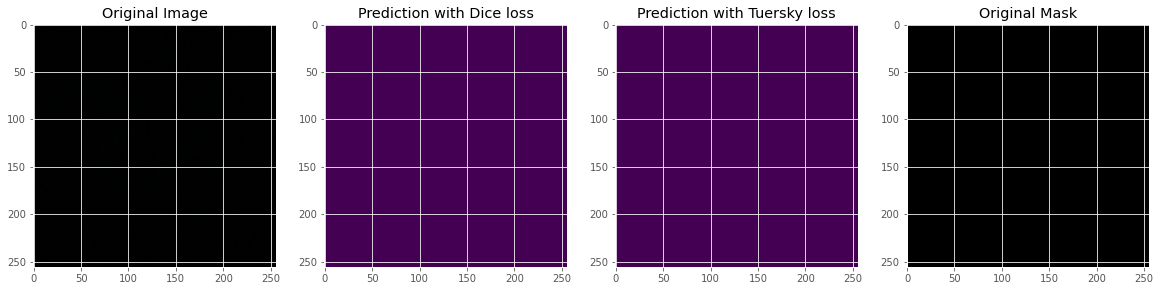

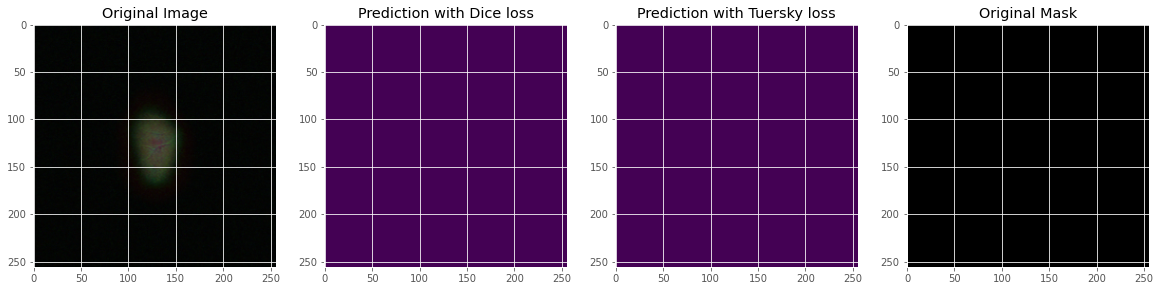

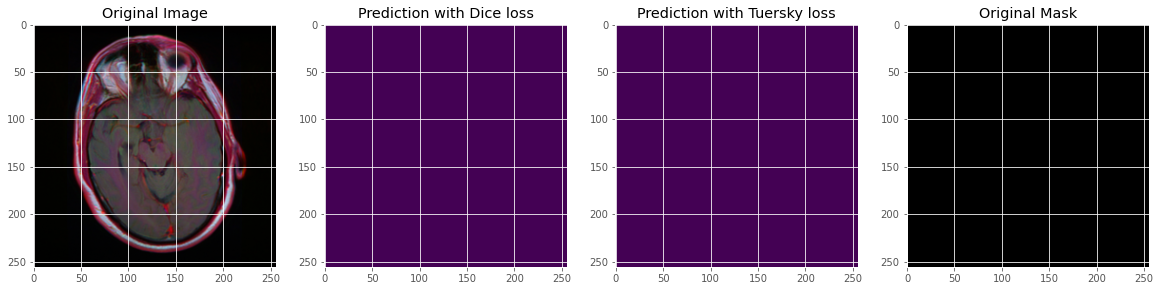

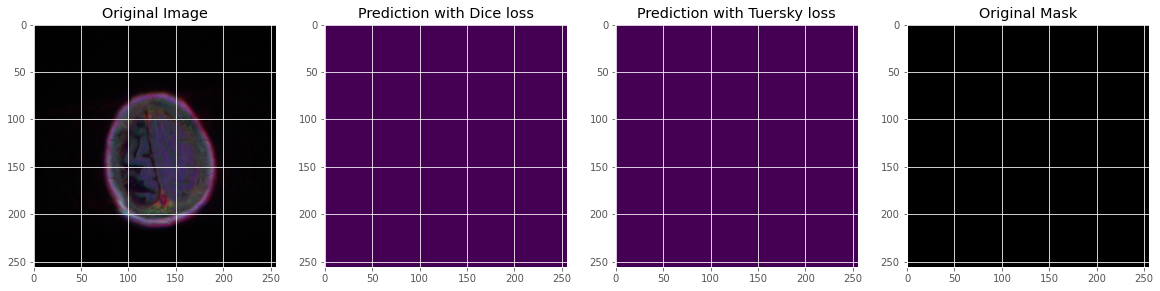

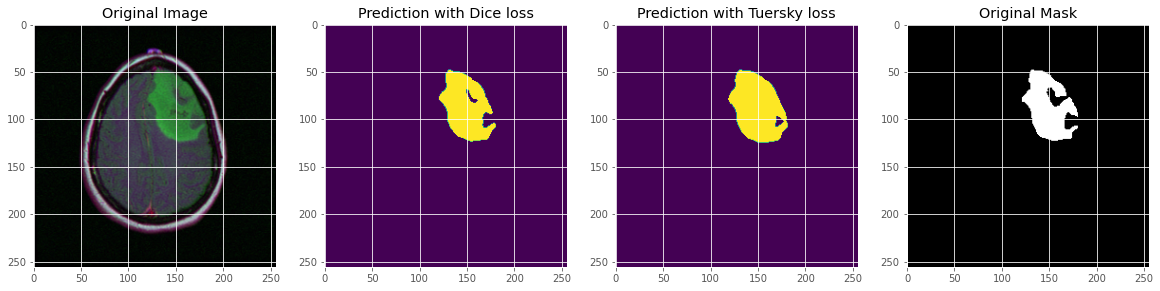

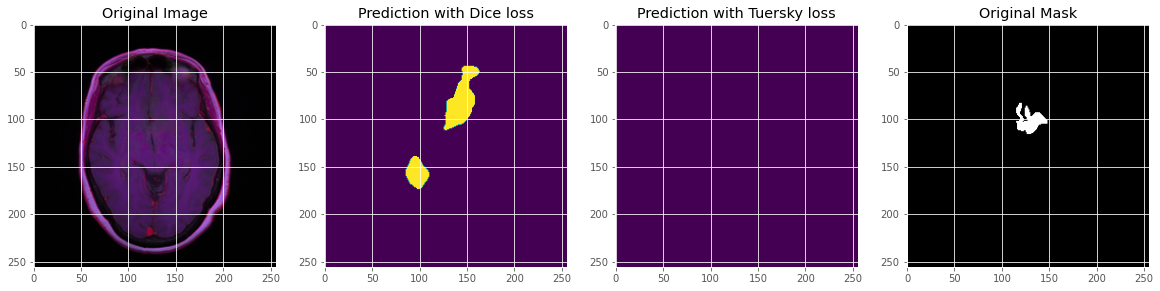

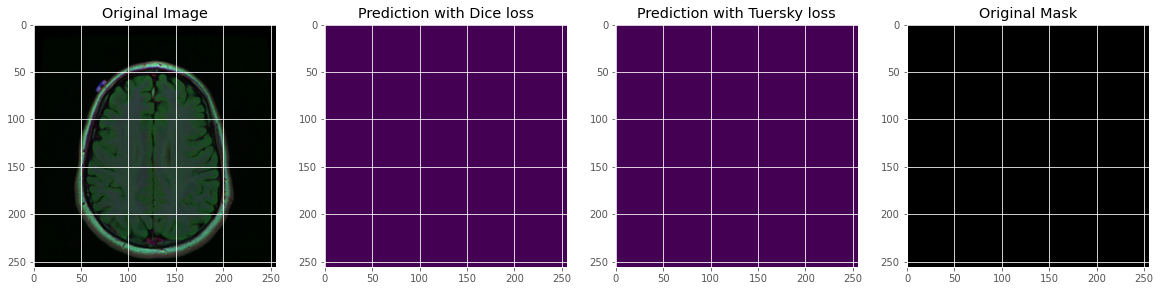

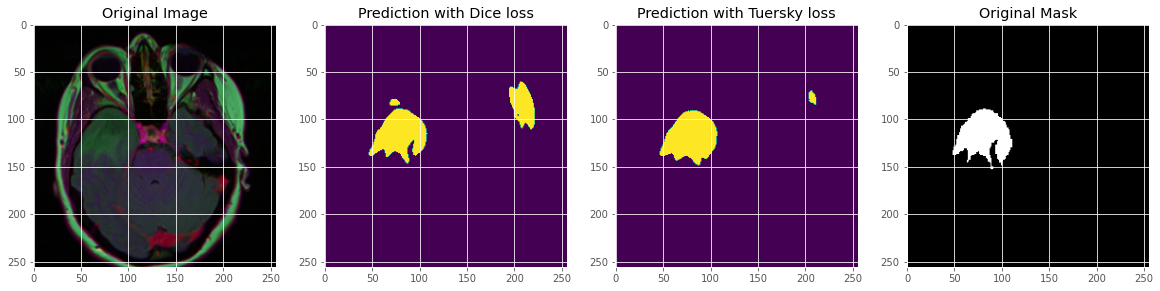

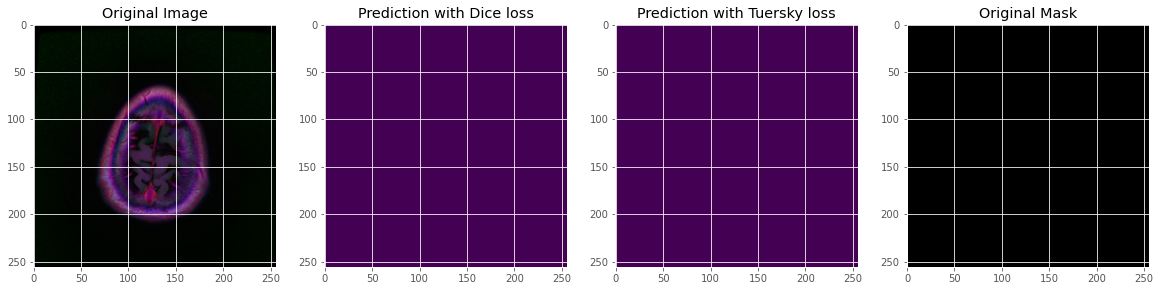

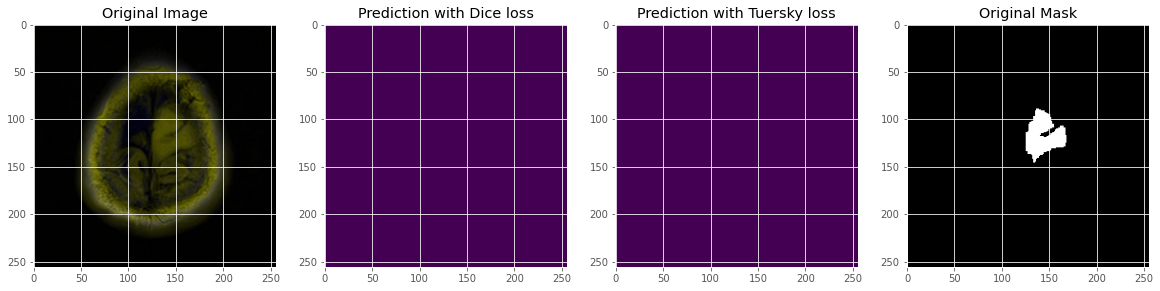

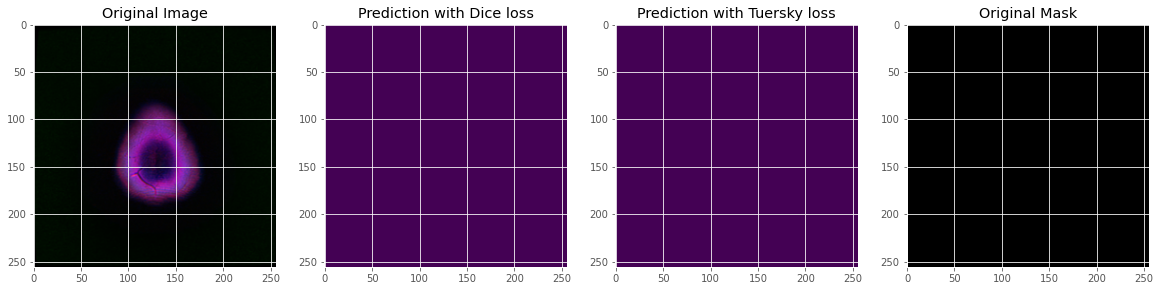

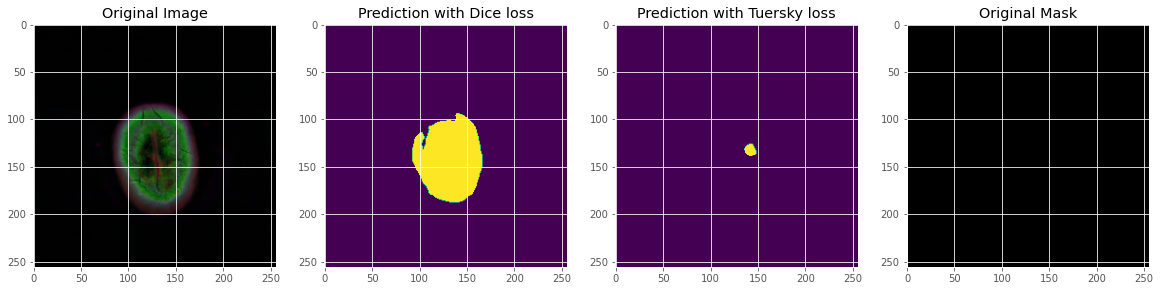

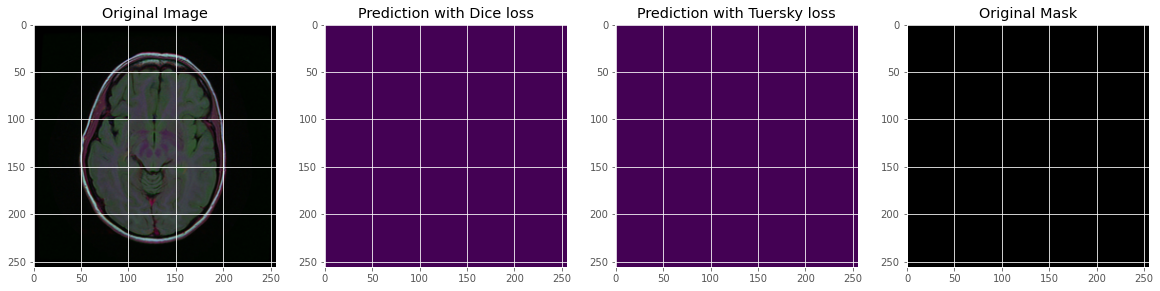

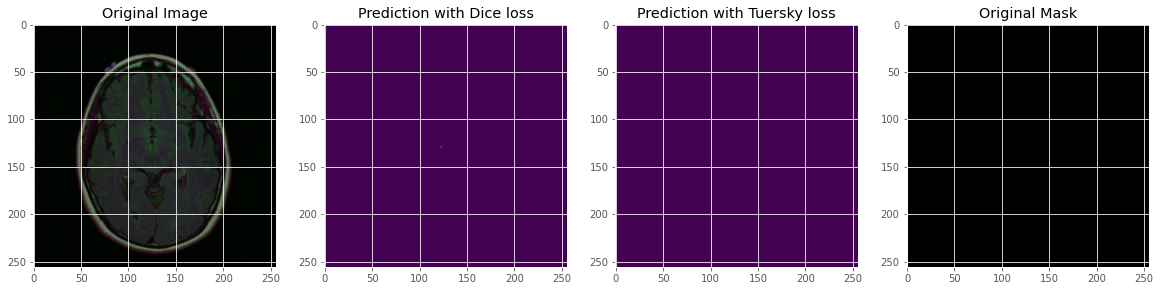

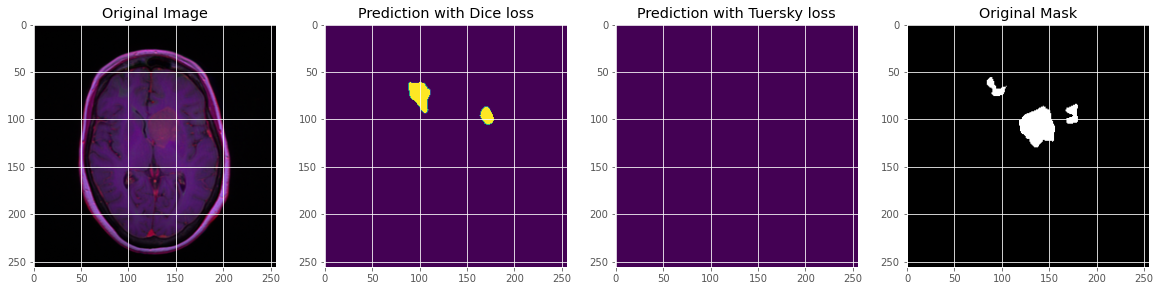

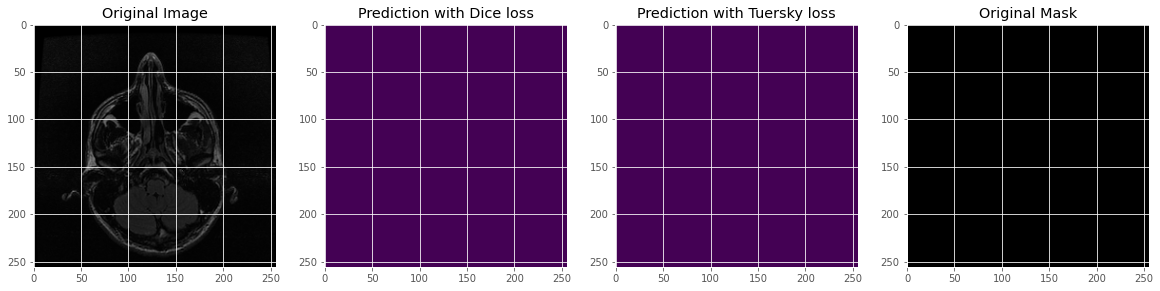

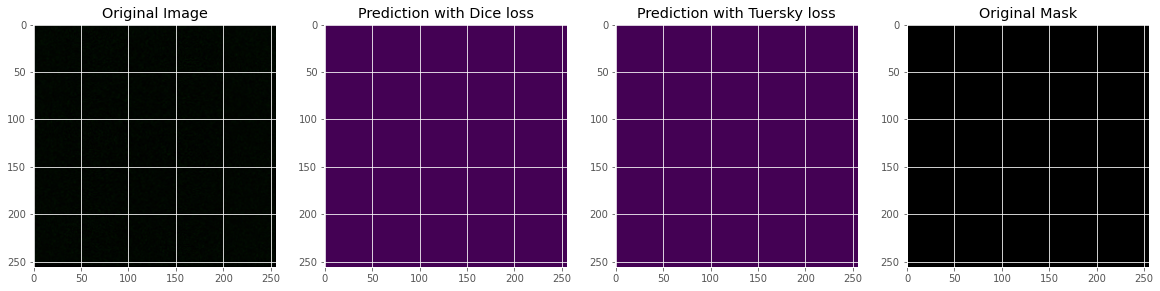

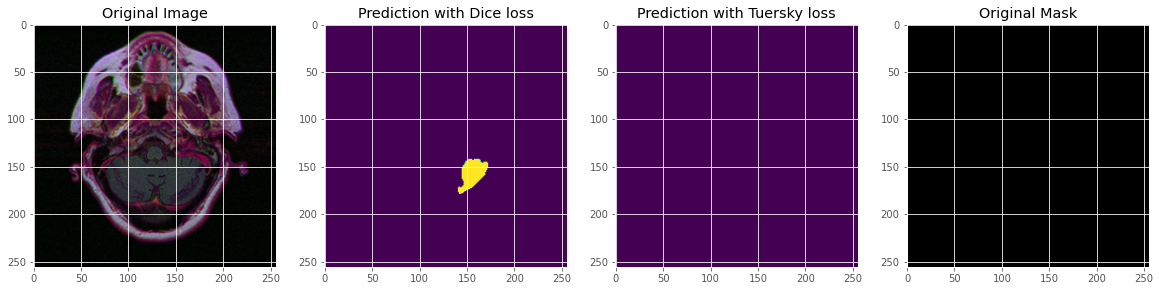

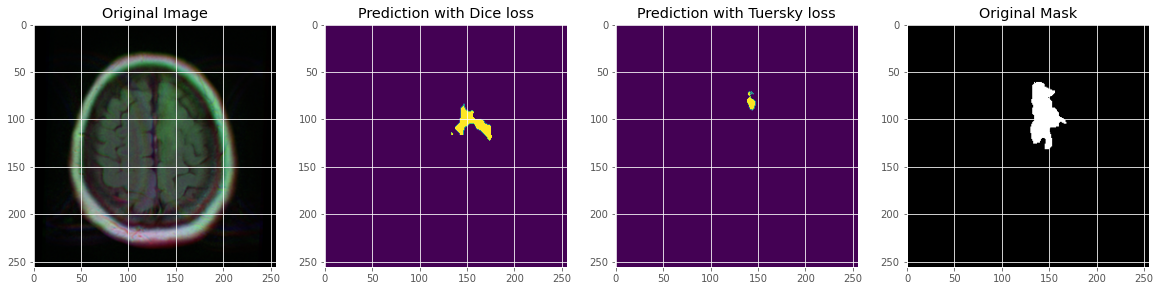

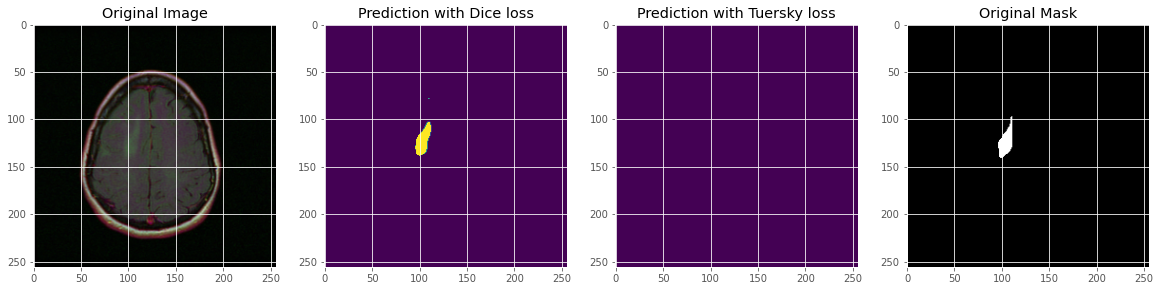

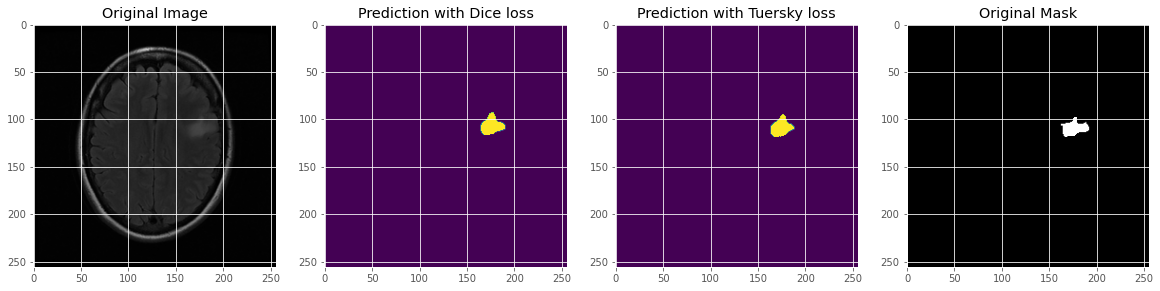

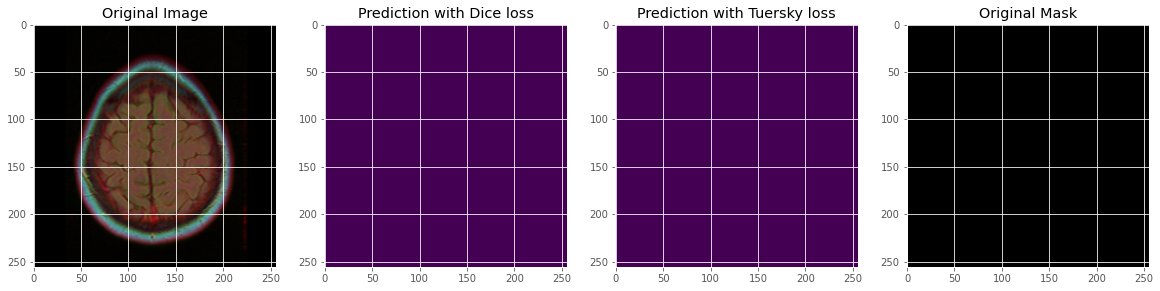

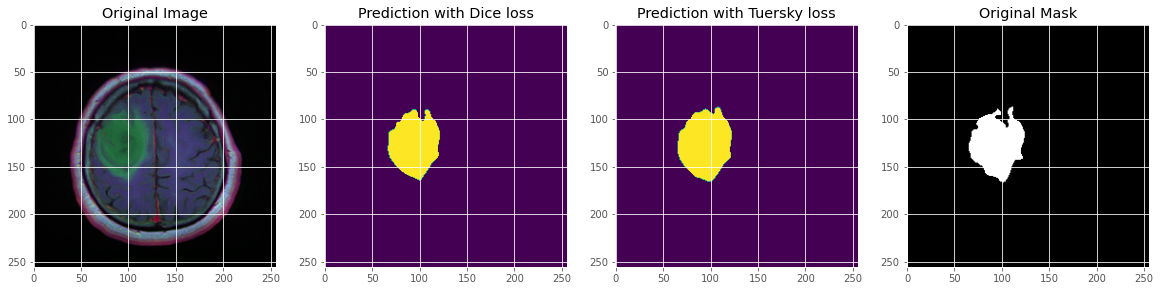

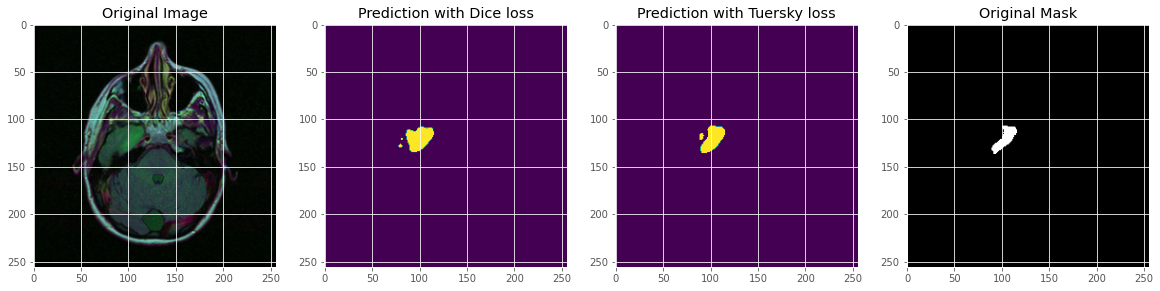

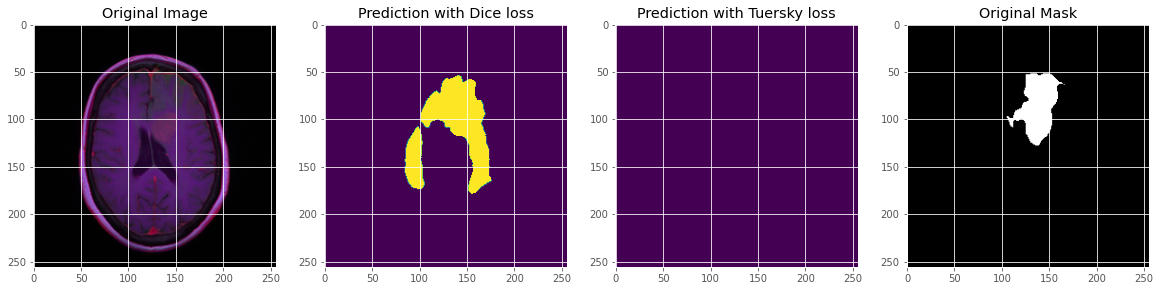

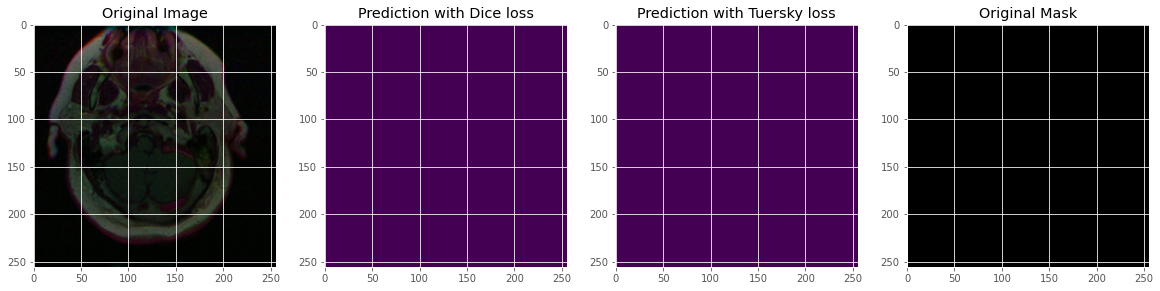

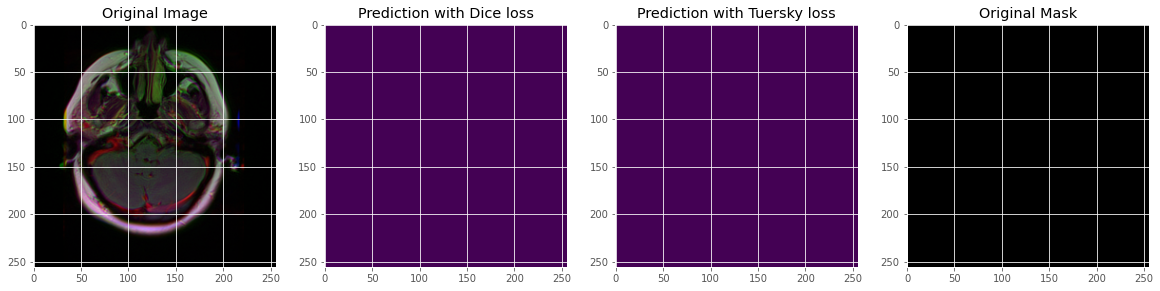

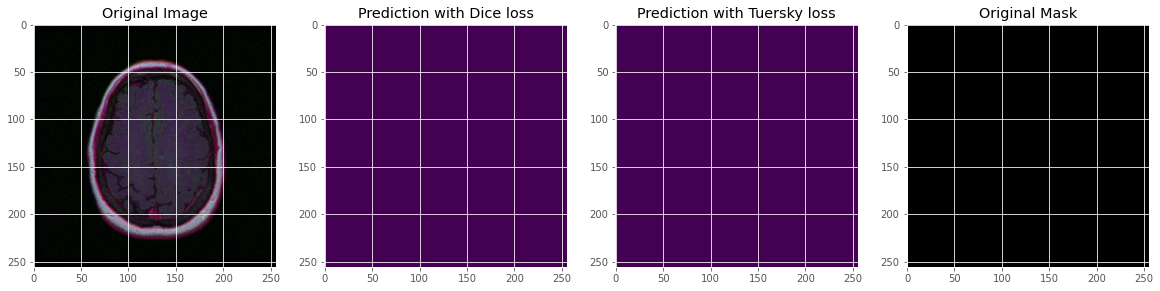

In [ ]:
for i in range(30):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[index])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred_1=model_1.predict(img)
    pred=model.predict(img)

    plt.figure(figsize=(20,20))
    plt.subplot(1,4,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,4,2)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction with Dice loss')
    plt.subplot(1,4,3)
    plt.imshow(np.squeeze(pred_1) > .5)
    plt.title('Prediction with Tuersky loss')
    plt.subplot(1,4,4)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.show()

As we can see not all predicted masks with both models correspond to the original ones, but we got a good iniztial step to improve the quality and accuracy of our dl framework for medical images segmentation in fMRI brain tumor.